## Objective: continue to improve performance using random forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 4

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.cross_validation import cross_val_score
import time

### Load train and test data

In [3]:
train_data = pd.read_csv('./data/train_data2.csv')
test_data = pd.read_csv('./data/test_data2.csv')
print train_data.shape, test_data.shape

(2153346, 63) (498687, 63)


In [4]:
predictors = list(train_data.columns.drop(['people_id', 'activity_id', 'outcome']))
label = 'outcome'

In [5]:
def model_fit(estimator, train_data, predictors, label, cv=True, cv_folds=3):
    """
    template to fit model and output score(accuracy and roc_auc), feature importance, and running time
    label: need to be string
    """
    start_time = time.time()
    # fit the model on the train data
    estimator.fit(train_data[predictors], train_data[label])
        
    # predict train data
    preds = estimator.predict(train_data[predictors])
    preds_proba = estimator.predict_proba(train_data[predictors])[:,1]
    
    # if true, perform cross-validation:
    if cv:
        cv_score = cross_val_score(estimator, train_data[predictors], train_data[label], cv=cv_folds, scoring='roc_auc')
    
    # report scores
    print "\nModel Scores:"
    print "Accuracy : {:.7f}".format(accuracy_score(train_data[label].values, preds))
    print "AUC Score (Train): {:.7f}".format(roc_auc_score(train_data[label], preds_proba))
    
    if cv:
        print "CV Scores : Mean - {:.7f} | Std - {:.7f} | Min - {:.7f} | Max - {:.7f}".format(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    # report feature importance
    feature_importance = pd.Series(estimator.feature_importances_, predictors).sort_values(ascending=False)
    feature_importance.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
        
    # report running time
    print "--- {} seconds ---".format(time.time() - start_time)

### Show the baseline of random forest using default settings

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

In [31]:
clf = RandomForestClassifier(random_state=1234)


Model Scores:
Accuracy : 0.9998207
AUC Score (Train): 0.9999997
CV Scores : Mean - 0.9327848 | Std - 0.0069999 | Min - 0.9230716 | Max - 0.9392961
--- 138.023171186 seconds ---


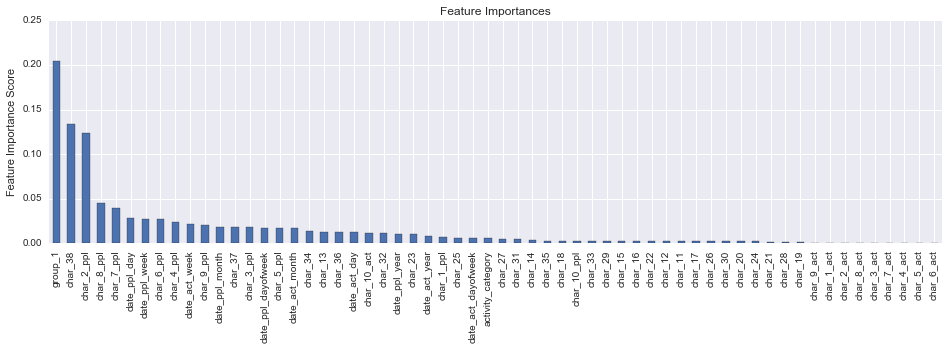

In [32]:
model_fit(clf, train_data, predictors, label)

- We can find the CV score improves from 0.83(in previous decision tree) to 0.93
- More features show importance compared with the decision tree

### Grid search on the random forest

In [40]:
param = {'min_samples_leaf' : [6,8,10],
        'max_features' : [8,9,10], # around sqrt(len(n_features))
        'criterion' : ['gini', 'entropy'] # try two criterion
         }

In [41]:
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=1234), 
                    param_grid = param, 
                    scoring='roc_auc',
                    n_jobs=4,
                    iid=False, 
                    cv=3)

In [42]:
grid_search.fit(train_data[predictors], train_data[label])

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_features': [8, 9, 10], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [43]:
grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=None, max_features=10, max_leaf_nodes=None,
             min_samples_leaf=8, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=1234, verbose=0,
             warm_start=False),
 {'criterion': 'entropy', 'max_features': 10, 'min_samples_leaf': 8},
 0.94538196446115685)

### The best criterion is entropy, max_feature is 10, and min_samples_leaf is 8

### continue to grid search on the max_features more than 10

In [49]:
param2 = {'max_features' : [10,20,30,40], # around sqrt(len(n_features))
         }

In [50]:
grid_search2 = GridSearchCV(estimator = RandomForestClassifier(random_state=1234, min_samples_leaf=8, criterion='entropy'), 
                    param_grid = param2, 
                    scoring='roc_auc',
                    n_jobs=4,
                    iid=False, 
                    cv=3)

In [51]:
grid_search2.fit(train_data[predictors], train_data[label])

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_features': [10, 20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [52]:
grid_search2.best_estimator_, grid_search2.best_params_, grid_search2.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=None, max_features=20, max_leaf_nodes=None,
             min_samples_leaf=8, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=1234, verbose=0,
             warm_start=False), {'max_features': 20}, 0.94951782594776934)

### Obtain the best max_features of 20

### grid search on 'n_estimators'

In [53]:
param3 = {
    'n_estimators' : [10, 20, 30, 40]
}

In [54]:
grid_search3 = GridSearchCV(estimator = RandomForestClassifier(random_state=1234, max_features=20, min_samples_leaf=8, criterion='entropy'), 
                    param_grid = param3, 
                    scoring='roc_auc',
                    n_jobs=4,
                    iid=False, 
                    cv=3)

In [55]:
grid_search3.fit(train_data[predictors], train_data[label])

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=20, max_leaf_nodes=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [10, 20, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [56]:
grid_search3.best_estimator_, grid_search3.best_params_, grid_search3.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=None, max_features=20, max_leaf_nodes=None,
             min_samples_leaf=8, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
             oob_score=False, random_state=1234, verbose=0,
             warm_start=False), {'n_estimators': 40}, 0.9546430615759558)

### The grid search gives us 0.954 with more estimators.

### fit the model with parameters from grid search

In [ ]:
model_fit(RandomForestClassifier(n_estimators=40, max_features=20, min_samples_leaf=8, criterion='entropy'), train_data, predictors, label)

- It shows that cv score improves up to 0.95, and more time consuming
- The feature importance goes back to top features

### output the prediction results

In [23]:
import datetime

In [7]:
clf = RandomForestClassifier(n_estimators=40, max_features=20, mincriterion='entropy')

In [8]:
clf.fit(train_data[predictors], train_data[label])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=30, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
preds = clf.predict(test_data[predictors])

In [19]:
submission = test_data[['activity_id', 'outcome']]

In [21]:
submission['outcome'] = preds

In [24]:
path = './data/submission_' + str(datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")) + '.csv'
submission.to_csv(path, index=False)
print ("Submission created.")

Submission created.
